In [2]:
#!jupyter nbconvert --to=script extendedifft_randomphase.ipynb

[NbConvertApp] Converting notebook extendedifft_randomphase.ipynb to script
[NbConvertApp] Writing 13481 bytes to extendedifft_randomphase.py


last edited on February 3, 2019, by Claire Valva

# IFFT for extended seasons with randomized phase

TO DO: implement transform routine, paying particular attention to which length of season is best as well as how many times phase should be randomized.

In [1]:
#choose whether or not to run the simulation again.
dosim = False

## packages/load files

In [2]:
#import packages
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import matplotlib.pyplot as plt
import scipy.integrate as sciint
import pandas as pd
import matplotlib.cm as cm
import matplotlib.ticker as tck
from math import pi
from sympy import solve, Poly, Eq, Function, exp, re, im
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.optimize import fsolve
from IPython.display import display, Markdown, Latex
import matplotlib.colors as colors
from seaborn import cubehelix_palette #for contour plot colors
import seaborn as sns
from cartopy.util import add_cyclic_point
from decimal import Decimal
import pickle
import time
import random

In [3]:
##pickle these two to check phase later
file_Name = "phase_check_pickle"
file_pickle = open(file_Name,'rb') 
d2_trans, d2_trans_nowind = pickle.load(file_pickle)

##get names to later match season + year to arrays and seasonal averaging
file_Name = "names_seasons"
file_pickle = open(file_Name,'rb') 
names_matched, indices_matched_time = pickle.load(file_pickle)

In [4]:
#original data (as fft coefficients, for comparing distributions to simulated)
d2_touse = d2_trans[0:len(d2_trans)-1]

In [5]:
#get phases of transforms, that were solved in phase_check notebook
file_Name = "test_phases_nowind"
file_pickle = open(file_Name,'rb') 
file = pickle.load(file_pickle)

## convert loaded objects in usable formats, average over seasons

In [6]:
#get zonal spacing array for plotting later
zonal_spacing = fftfreq(240,1.5)
zonal_spacing = 1/zonal_spacing
zonal_spacing= 360 / zonal_spacing

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#puts arrays into list formats (not sure exactly why this is necessary)
#however it is, otherwise isn't compatible with modulo operation
tested = [[[list(leaf)[1] for leaf in stem] for stem in trunk] for trunk in file]
phases = [[[np.remainder(leaf, 2*pi) 
            for leaf in stem] 
           for stem in trunk] 
          for trunk in tested]

amps = [[[list(leaf)[0] for leaf in stem] for stem in trunk] for trunk in file]

In [8]:
#sorts phases and amplitudes into seasons, whose index matches list: seasons
seasons = ['winter', 'spring', 'summer', 'fall']

#sort them into each season
d2_seasons = [[phases[i] for i in range(len(d2_touse) - 1) 
               if names_matched[i][1] == part] for part in seasons]
#sort them into each season
season_phases = [[phases[i] for i in range(len(phases)) 
               if names_matched[i][1] == part] for part in seasons]

#sort them into each season
season_amps = [[amps[i] for i in range(len(d2_touse) - 1) 
               if names_matched[i][1] == part] for part in seasons]

In [9]:
#test = [[len(year[0]) for year in season] for season in season_amps]

In [10]:
#adjust for winter averaging
#TO DO: come up with better procedure rather 
#current: chopping off edges to make the same length for averaging
norml = 359
longl = 363

def padded(to_pad, index):
    length = len(to_pad)
    if index == 0:
        zeros = longl - length
        to_pad = list(to_pad)
        for i in range(zeros):
            to_pad.append(0)
        return to_pad
    else:
        return to_pad

In [11]:
#pad rows with zeros to account for leap year
season_amps_adj = [[[padded(row, index = i)  
                     for row in entry] for entry in season_amps[i]] for i in range(4)]

In [12]:
#get average amplitude and phases for each season
avg_amps = [np.average(season, axis = 0) 
            for season in season_amps_adj]
std_amps = [np.std(season, axis = 0) 
            for season in season_amps_adj]

below looks at the relation between average wave amplitude and frequency/wavenumber

/home/clairev/anaconda3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


<Figure size 432x288 with 0 Axes>

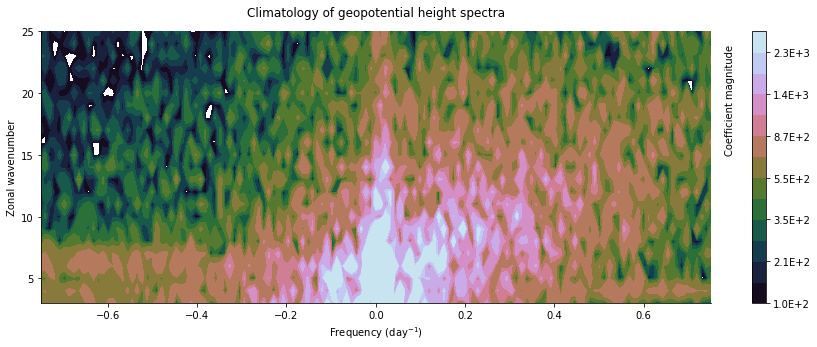

In [13]:
#check to see that this working, by seeing if spectra looks similar to actual data
test_dat = avg_amps[2]
frequencies = fftfreq(len(test_dat[1]), 0.25)

#set what you wanna crop
max_z = 40
max_f = 1

#crop the data, only keep the positive frequencies
cropped = [[test_dat[i][j] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] <= max_z and zonal_spacing[i] >= 0]
            for j in range(len(frequencies)) 
            if np.abs(frequencies[j]) <= max_f]

cropf = [counted for counted in frequencies if np.abs(counted) <= max_f]# and counted != 0]
cropz = [zonal_spacing[i] for i in range(len(zonal_spacing)) 
                if zonal_spacing[i] <= max_z and zonal_spacing[i] >= 0]

x = cropf
y = cropz
X, Y = np.meshgrid(x,y)
X = np.flip(X)
Z = np.transpose(np.abs(cropped))

#add cyclic point for plotting
x = np.array(x)
testZ = [fftshift(entry) for entry in Z]
testZ = np.array(testZ)

dataout, lonsout = add_cyclic_point(testZ,fftshift(x))
x = lonsout
y = y
X, Y = np.meshgrid(x,y)
X = np.flip(X)

#set color coding
level_set_less = [np.percentile(dataout, j*10) for j in range(1,11)]
for j in range(1,5):
    level_set_less.append(np.percentile(dataout, 90 + 2*j))
            
level_set_less.sort()
colors_set = sns.color_palette("cubehelix", 14)

#plot it
plt.clf();
plt.figure(figsize=(15, 5));
CF = plt.contourf(X,Y,dataout, colors = colors_set, levels = level_set_less,)

#color bar and labeling
CBI = plt.colorbar(CF)
ax = CBI.ax
ax.text(-2,0.925,'Coefficient magnitude',rotation=90)
labels = ["{:.1E}".format(Decimal(entry)) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel(r"Frequency (day$^{-1}$)")
plt.ylim(ymax = 25, ymin = 3)
plt.xlim(xmax = 0.75, xmin = -0.75)
plt.ylabel("Zonal wavenumber")
plt.title("Climatology of geopotential height spectra", pad = 15)

#formatting
sns.set_style("ticks")
sns.set_context("poster")
sns.despine()

In [14]:
def entry_fft(amp, phase = random.uniform(0, 2*pi)):
    #takes amplitude and phase to give corresponding fourier coeff
    entry = amp*np.exp(1j*phase)
    return entry

It turns out that the above function (entry_fft) is not the most efficient way to compute the fourier coefficients from the amplitude and phase with very large arrays. None the less, it does work for current purposes, and will be used for the time being.

REMINDER: As for the below, note that when entry_fft is used, the phase is randomized -- so this must be run previous to each ifft operation for the randomization in phase to work.

In [15]:
#use entry_fft function to return amplitude and random phase (do twice for later comparison)
coeff_entries_01 = [[[entry_fft(amp = timed, phase = random.uniform(0, 2*pi))
                 for timed in wave]
                for wave in season] 
               for season in avg_amps]


coeff_entries_02 = [[[entry_fft(amp = timed, phase = random.uniform(0, 2*pi))
                 for timed in wave]
                for wave in season] 
               for season in avg_amps]

/home/clairev/anaconda3/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


<Figure size 432x288 with 0 Axes>

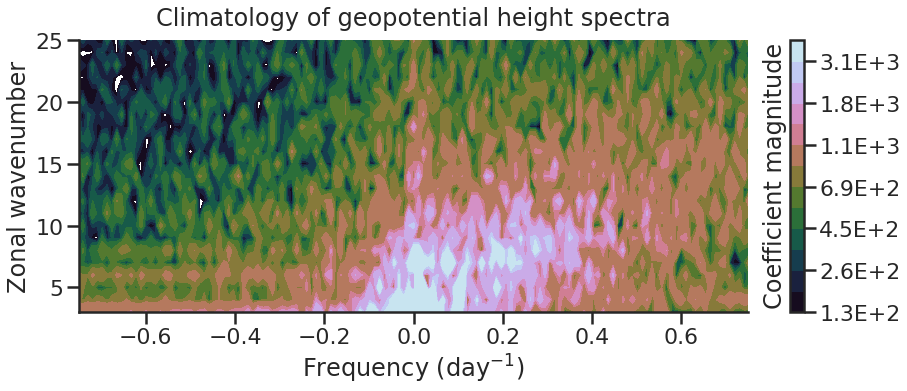

In [16]:
#check to see that this working, by seeing if spectra looks similar to actual data
test_dat = coeff_entries_01[1]
frequencies = fftfreq(len(test_dat[1]), 0.25)

#set what you wanna crop
max_z = 40
max_f = 1

#crop the data, only keep the positive frequencies
cropped = [[test_dat[i][j] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] <= max_z and zonal_spacing[i] >= 0]
            for j in range(len(frequencies)) 
            if np.abs(frequencies[j]) <= max_f]

cropf = [counted for counted in frequencies if np.abs(counted) <= max_f]# and counted != 0]
cropz = [zonal_spacing[i] for i in range(len(zonal_spacing)) 
                if zonal_spacing[i] <= max_z and zonal_spacing[i] >= 0]

x = cropf
y = cropz
X, Y = np.meshgrid(x,y)
X = np.flip(X)
Z = np.transpose(np.abs(cropped))

#add cyclic point for plotting
x = np.array(x)
testZ = [fftshift(entry) for entry in Z]
testZ = np.array(testZ)

dataout, lonsout = add_cyclic_point(testZ,fftshift(x))
x = lonsout
y = y
X, Y = np.meshgrid(x,y)
X = np.flip(X)

#set color coding
level_set_less = [np.percentile(dataout, j*10) for j in range(1,11)]
for j in range(1,5):
    level_set_less.append(np.percentile(dataout, 90 + 2*j))
            
level_set_less.sort()
colors_set = sns.color_palette("cubehelix", 14)

#plot it
plt.clf();
plt.figure(figsize=(15, 5));
CF = plt.contourf(X,Y,dataout, colors = colors_set, levels = level_set_less,)

#color bar and labeling
CBI = plt.colorbar(CF)
ax = CBI.ax
ax.text(-2,0.925,'Coefficient magnitude',rotation=90)
labels = ["{:.1E}".format(Decimal(entry)) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel(r"Frequency (day$^{-1}$)")
plt.ylim(ymax = 25, ymin = 3)
plt.xlim(xmax = 0.75, xmin = -0.75)
plt.ylabel("Zonal wavenumber")
plt.title("Climatology of geopotential height spectra", pad = 15)

#formatting
sns.set_style("ticks")
sns.set_context("poster")
sns.despine()

## Test ifft operations

For some reason, using the ifft to just give a season of normal length produces some very strange results, which are shown below. However, when the season length is extended, something about this seems to give results that certainly make more sense

TO DO: Figure out why this is. 

In [17]:
#initial inverse transform
test_ifft = [ifft(entry) for entry in coeff_entries_01]

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

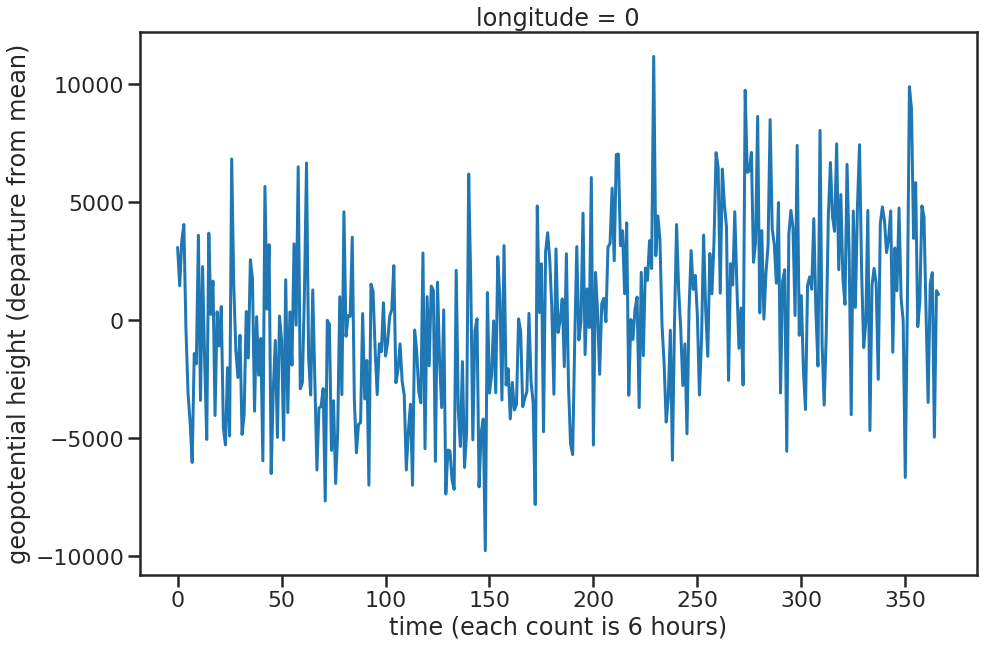

In [18]:
count = list(range(len(test_ifft[1][7])))

plt.clf();
plt.figure(figsize=(15, 10));
plt.plot(count,test_ifft[1][0])
plt.ylabel("geopotential height (departure from mean)")
plt.xlabel("time (each count is 6 hours)")
plt.title("longitude = 0")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

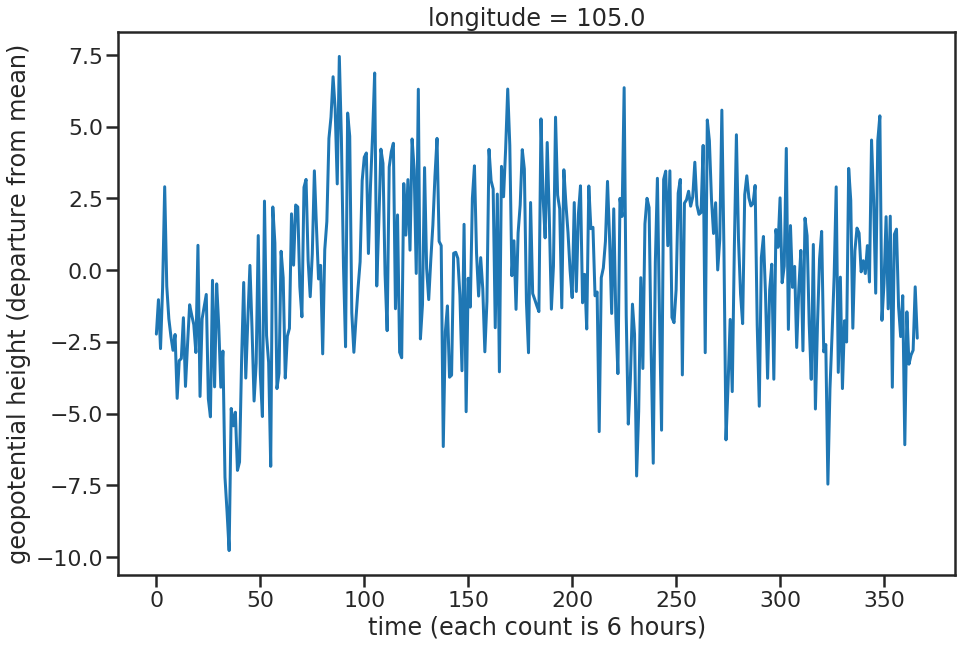

In [19]:
plt.clf();
plt.figure(figsize=(15, 10));
plt.plot(count,test_ifft[1][70])
plt.ylabel("geopotential height (departure from mean)")
plt.xlabel("time (each count is 6 hours)")
plt.title("longitude = " + str(70*1.5))
plt.show()

### Try ifft for a longer stretch of time

In [20]:
#write functions to make a longer ifft
def ext_row(row, n):
    ext_f = np.zeros(((len(row) - 1) * n + 1,), dtype="complex128")
    ext_f[::n] = row * n
    
    return ext_f

def ext_ifft_new(n, input_array):
    #add the zeros onto each end
    ext_f = [ext_row(entry,n) for entry in input_array]
    
    #make up for the formulat multiplying for array length
    olddim = len(input_array[5])
    newdim = len(ext_f[0])
    mult = newdim/olddim
    
    #ext_f = np.multiply(mult, ext_f)
    adjusted_tested = np.fft.ifft2(ext_f)
    
    return adjusted_tested

For the following longer season simulations -- several items are compared:

test_season1/long_ifft1 = coeff_entries_01, simulated for 150 times the length of the initial season

test_season2 = coeff_entries_02, simulated for 150 times the length of the initial season

test_season3 = coeff_entries_01, simulated for 50 times the length of the initial season

In [21]:
#simulate the first season
test_season1 = coeff_entries_01[0]
test_season1 = [np.array(leaf) for leaf in test_season1]
long_ifft1 = ext_ifft_new(150,test_season1)

In [22]:
#simulate the second season
test_season2 = coeff_entries_02[0]
test_season2 = [np.array(leaf) for leaf in test_season2]
long_ifft2 = ext_ifft_new(150,test_season2)

In [23]:
#simulate the third season
long_ifft3 = ext_ifft_new(20,test_season1)

#### Plot Results

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

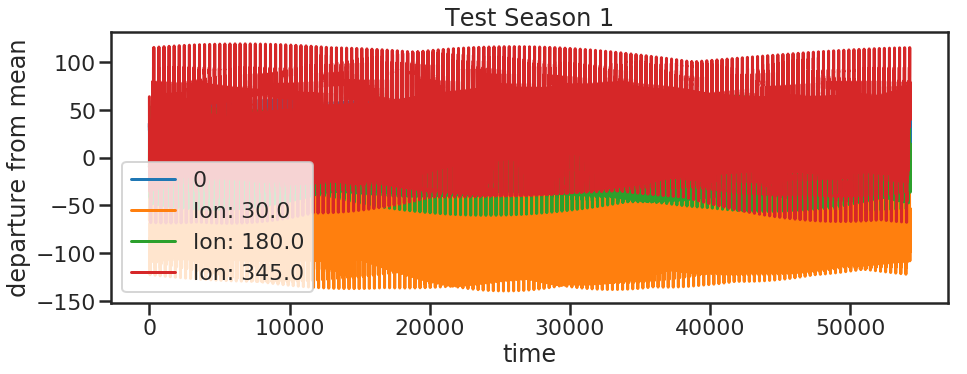

In [24]:
#plot results for 1st season
count1 = list(range(len(long_ifft1[0])))

plt.clf();
plt.figure(figsize=(15, 5));
plt.plot(count1,long_ifft1[0], label = "0")
plt.plot(count1,long_ifft1[20], label = "lon: " + str(20*1.5))
plt.plot(count1,long_ifft1[120], label = "lon: " + str(120*1.5))
plt.plot(count1,long_ifft1[230], label = "lon: " + str(230*1.5))
plt.ylabel("departure from mean")
plt.xlabel("time")
plt.title("Test Season 1")
plt.legend()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

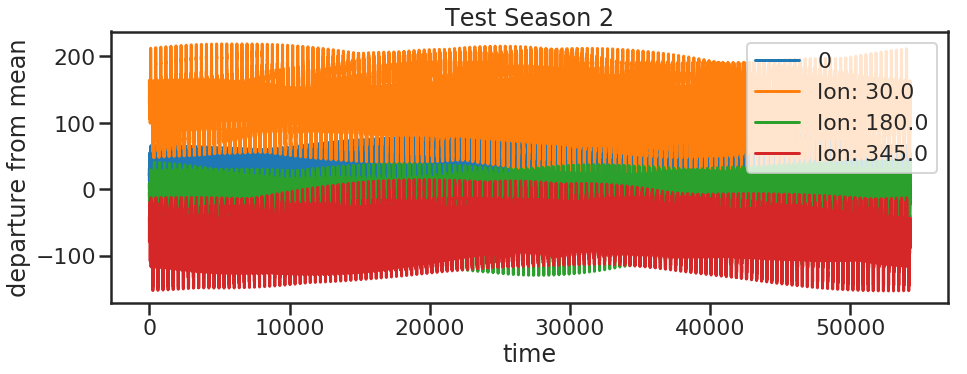

In [25]:
#plot results for 2nd season
count2 = list(range(len(long_ifft2[0])))

plt.clf();
plt.figure(figsize=(15, 5));
plt.plot(count2,long_ifft2[0], label = "0")
plt.plot(count2,long_ifft2[20], label = "lon: " + str(20*1.5))
plt.plot(count2,long_ifft2[120], label = "lon: " + str(120*1.5))
plt.plot(count2,long_ifft2[230], label = "lon: " + str(230*1.5))
plt.ylabel("departure from mean")
plt.xlabel("time")
plt.title("Test Season 2")
plt.legend()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

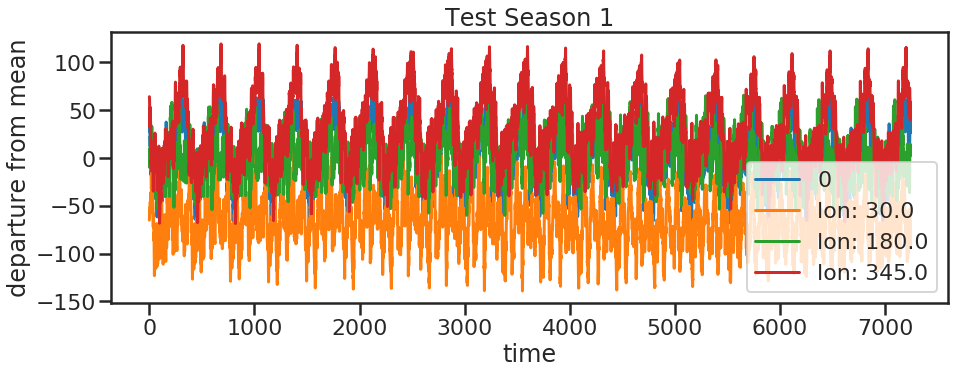

In [26]:
#plot results for 3rd season
count3 = list(range(len(long_ifft3[0])))

plt.clf();
plt.figure(figsize=(15, 5));
plt.plot(count3,long_ifft3[0], label = "0")
plt.plot(count3,long_ifft3[20], label = "lon: " + str(20*1.5))
plt.plot(count3,long_ifft3[120], label = "lon: " + str(120*1.5))
plt.plot(count3,long_ifft3[230], label = "lon: " + str(230*1.5))
plt.ylabel("departure from mean")
plt.xlabel("time")
plt.title("Test Season 1")
plt.legend()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

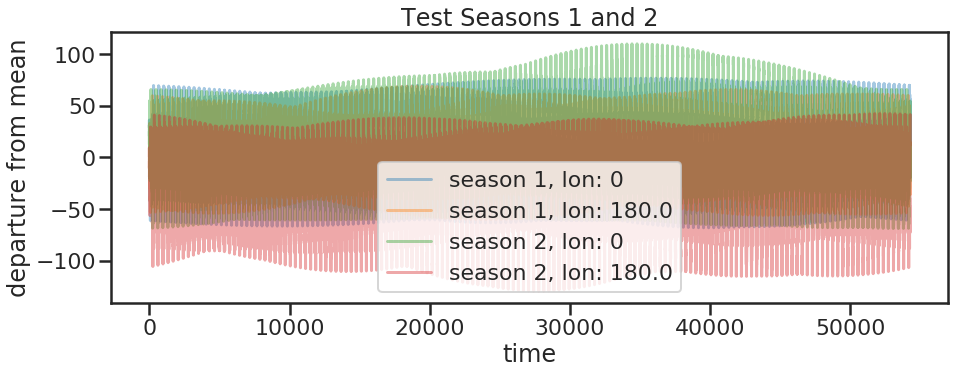

In [27]:
#compare seasons 1 and 2

plt.clf();
plt.figure(figsize=(15, 5));
plt.plot(count1,long_ifft1[0], label = "season 1, lon: 0", alpha = 0.4)
plt.plot(count1,long_ifft1[120], label = "season 1, lon: " + str(120*1.5), alpha = 0.4)
plt.plot(count2,long_ifft2[0], label = "season 2, lon: 0", alpha = 0.4)
plt.plot(count2,long_ifft2[120], label = "season 2, lon: " + str(120*1.5), alpha = 0.4)
plt.ylabel("departure from mean")
plt.xlabel("time")
plt.title("Test Seasons 1 and 2")
plt.legend()
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<Figure size 432x288 with 0 Axes>

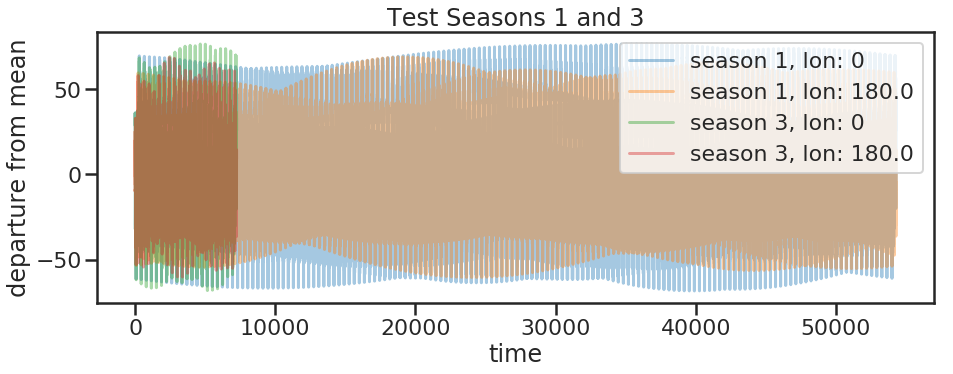

In [28]:
#compare seasons 1 and 3

plt.clf();
plt.figure(figsize=(15, 5));
plt.plot(count1,long_ifft1[0], label = "season 1, lon: 0", alpha = 0.4)
plt.plot(count1,long_ifft1[120], label = "season 1, lon: " + str(120*1.5), alpha = 0.4)
plt.plot(count3,long_ifft3[0], label = "season 3, lon: 0", alpha = 0.4)
plt.plot(count3,long_ifft3[120], label = "season 3, lon: " + str(120*1.5), alpha = 0.4)
plt.ylabel("departure from mean")
plt.xlabel("time")
plt.title("Test Seasons 1 and 3")
plt.legend()
plt.show()

While I am not completely sure, it seems like the short seasons add more variability. A possible reason for this could be that the longer simulation is similar to smoothing some data, as there are many wavenumbers and frequencies that are not met

#### Plot the above seasons as a histogram

In [29]:
#flatten season for plotting
flatten = lambda l: [item for sublist in l for item in sublist]

flat_1 = flatten(long_ifft1)
flat_2 = flatten(long_ifft2)
flat_3 = flatten(long_ifft3)

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:761: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2059: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


<Figure size 432x288 with 0 Axes>

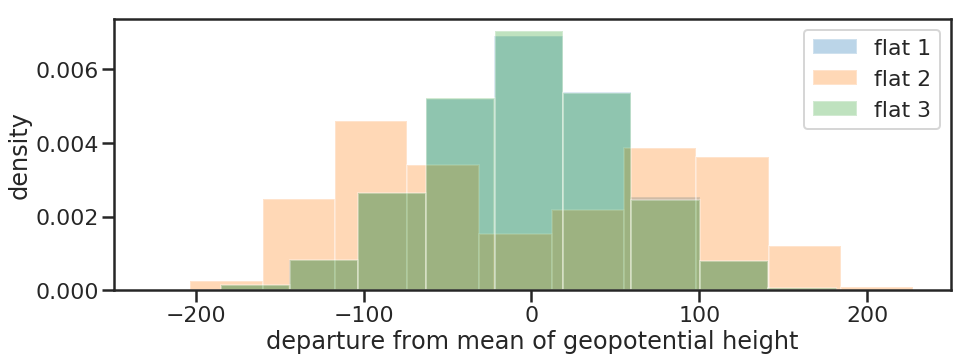

In [30]:
#show histograms
plt.clf();
plt.figure(figsize=(15, 5));
plt.hist(flat_1, label = "flat 1", alpha = 0.3, density=True, bins = 10)
plt.hist(flat_2, label = "flat 2", alpha = 0.3, density=True, bins = 10 )
plt.hist(flat_3, label = "flat 3", alpha = 0.3, density=True, bins = 10)
plt.ylabel("density")
plt.xlabel("departure from mean of geopotential height")
plt.legend()
plt.show()

## Repeat IFFT for better stats

In [31]:
def combined(amps, length):
    #combines generation of random phase with inverse transform
    newarray = [[entry_fft(amp = timed, phase = random.uniform(0, 2*pi)) for timed in wave]
                for wave in amps]
    newarray = [np.array(leaf) for leaf in newarray]
    iffted = ext_ifft_new(length, newarray)
    return iffted

In [31]:
def repeater(season, length, times):
    #repeats the phase creation and inverse transform
    newarray = [combined(season,length) for leaf in range(times)] 
    return(newarray)

In [32]:
#do simulation, or just load the files
if dosim == True:
    repeated_tests = [repeater(avg_amps[i], 50, 10) for i in range(4)]
    
    file_name = "randomphase_sim"
    file_pickle = open(file_name,"wb")
    pickle.dump(repeated_tests, file_pickle)
    file_pickle.close()
else:
    file_name = "randomphase_sim"
    file_pickle = open(file_name,"rb") 
    repeated_tests = pickle.load(file_pickle)

### Plot results of the longer simulation

In [39]:
repeated_tests[1][1] == repeated_tests[1][3]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [36]:
#flatten lists for histograms -- both for individual season plotting, then for total
flat_seasons_ind = np.real([[flatten(season) for season in section] 
                            for section in repeated_tests])
flat_seasons_all = np.real([flatten(season) for season in flat_seasons_ind])

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:761: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2059: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


<Figure size 432x288 with 0 Axes>

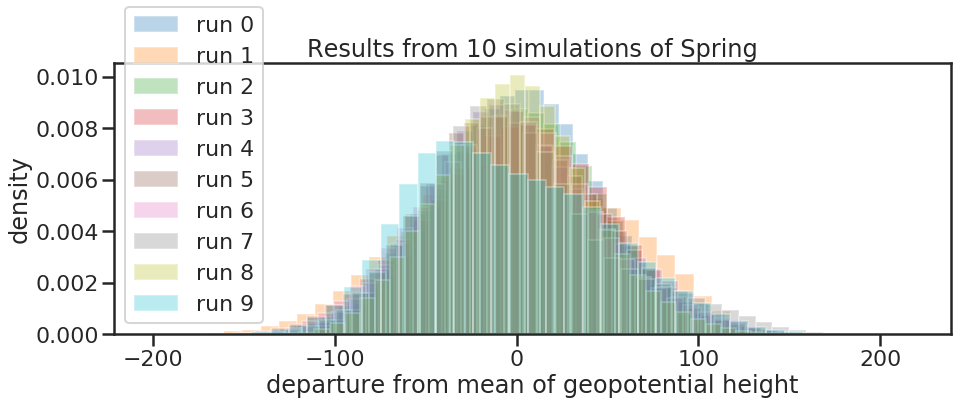

In [42]:
#show histograms, with each individual season for spring, 
#see results of repeated phase randomization in variation
plt.clf();
plt.figure(figsize=(15, 5));
for i in range(len(flat_seasons_ind[1])):
    plt.hist(flat_seasons_ind[1][i], label = "run " + str(i), 
             alpha = 0.3, density=True, bins = 40)

plt.ylabel("density")
plt.xlabel("departure from mean of geopotential height")
plt.legend()
plt.title("Results from 10 simulations of Spring")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:761: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:814: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/clairev/anaconda3/lib/python3.6/site-packages/matplotlib/transforms.py:2059: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

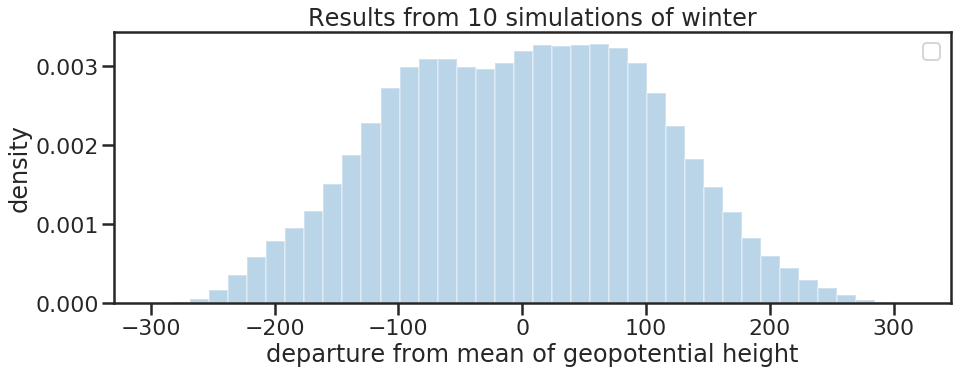

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

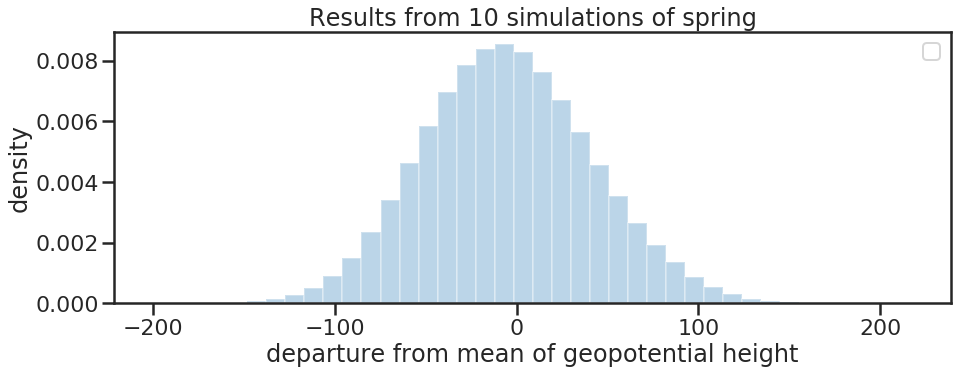

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

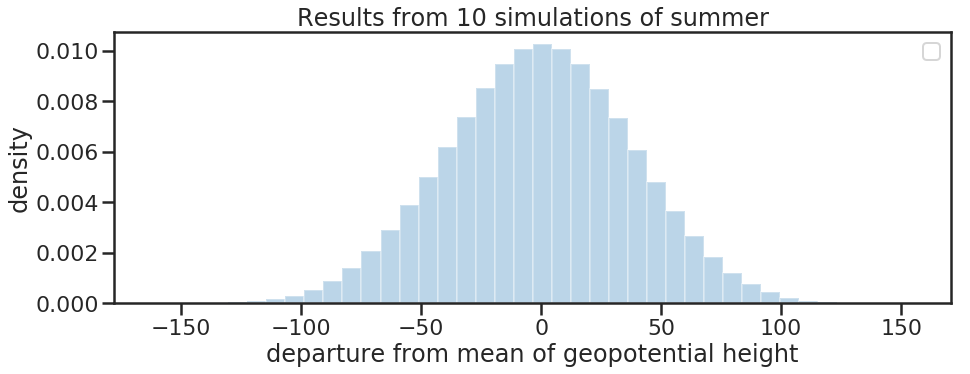

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

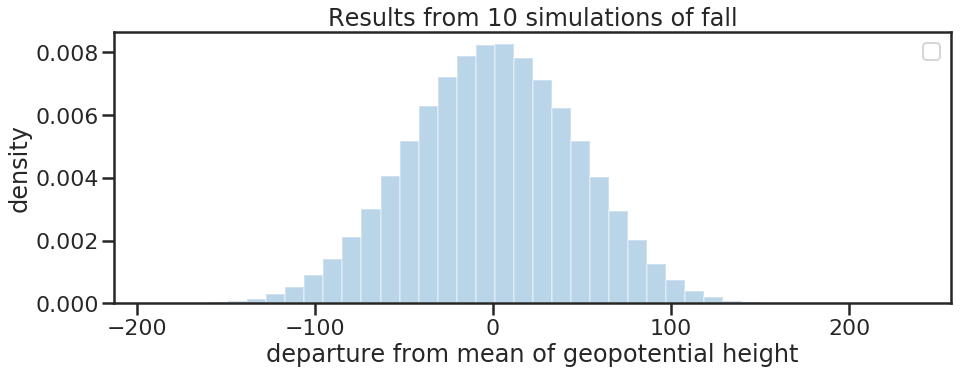

In [44]:
#show histograms, for each total season
for k in range(4):
    
    plt.clf();
    plt.figure(figsize=(15, 5));
    plt.hist(flat_seasons_all[k],
             alpha = 0.3, density=True, bins = 40)

    plt.ylabel("density")
    plt.xlabel("departure from mean of geopotential height")
    plt.legend()
    plt.title("Results from 10 simulations of " + seasons[k])
    
    
    plt.show()